# Long notebook

# General Exploratory Data Analysis

# Predictors:

# XGBoost

One of our earlier attempts utilized the XGBoost algorithm. The preprocessing we did was removing targets (pv_measurement), where the value remained constant for over 18 hours. We assumed this to be an error in the measurements. As the targets variables are on an hourly interval and the weather features are each quarter hour - we simply merged the X and y dataframes on every whole hour. For feature engineering we created some time based features such as hour, dayofyear, month etc. We tried running the model with different validation data and removing various features based on low importance. Ultimately the best result we got with this model was 154.768849 on Kaggle. This version simply used all the 45 weather features on each location. And only trained on actual observed weather. Regarding model interpretation we looked at the feature importances for each location, in addition to using the X_train_estimated weather as a local test set. We looked at the plots for the model predictions vs the plots of the actual pv_measurements. We also printed the largest errors the model made to try to interpret what went wrong.

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


### Reading in files and indexing them on time

In [74]:
targets_a = pd.read_parquet('data/A/train_targets.parquet')
targets_b = pd.read_parquet('data/B/train_targets.parquet')
targets_c = pd.read_parquet('data/C/train_targets.parquet')
targets_a = targets_a.set_index('time')
targets_b = targets_b.set_index("time")
targets_c = targets_c.set_index("time")


In [75]:
X_train_observed_a = pd.read_parquet('data/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('data/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('data/C/X_train_observed.parquet')
X_train_observed_a = X_train_observed_a.set_index("date_forecast")
X_train_observed_b = X_train_observed_b.set_index("date_forecast")
X_train_observed_c = X_train_observed_c.set_index("date_forecast")


In [76]:
X_train_estimated_a = pd.read_parquet('data/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('data/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('data/C/X_train_estimated.parquet')
X_train_estimated_a = X_train_estimated_a.set_index("date_forecast")
X_train_estimated_b = X_train_estimated_b.set_index("date_forecast")
X_train_estimated_c = X_train_estimated_c.set_index("date_forecast")


In [77]:
X_test_estimated_a = pd.read_parquet('data/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('data/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('data/C/X_test_estimated.parquet')
X_test_estimated_a = X_test_estimated_a.set_index("date_forecast")
X_test_estimated_b = X_test_estimated_b.set_index("date_forecast")
X_test_estimated_c = X_test_estimated_c.set_index("date_forecast")


### Helper functions

In [78]:
def plot_ts(y: pd.DataFrame, x:pd.DataFrame, start, end, feature, shareX: bool):
    """
    Plots all the y arrays, then all the x arrays.
    """
    fig, axs = plt.subplots(len(x)+len(y), 1, figsize=(15,10), sharex=shareX)
    i = 0
    for df in y:
        df[(df.index >= start) & (df.index <= end)].resample("H").mean().plot(ax=axs[i])
        i += 1
    
    for df in x:
        df[(df.index >= start) & (df.index <= end)].resample("H").mean()[feature].plot(ax=axs[i], label=feature, color="red")
        axs[i].legend()
        i += 1
    
            
def plot_ts1(y: pd.DataFrame, x:pd.DataFrame, start, end, feature, shareX: bool):
    """
    Plots the y and x values directly under each other for each location
    """
    
    if len(x) != len(y):
        print("Error: arrays 'y' and 'x' are different lengths. Please provide equal sized arrays.")
    else:
        fig, axs = plt.subplots(len(x)+len(y), 1, figsize=(15,10), sharex=shareX)
        i = 0
        for df_y, df_x in zip(y, x):
                df_y[(df_y.index >= start) & (df_y.index <= end)].resample("H").mean().plot(ax=axs[i])
                i += 1
                df_x[(df_x.index >= start) & (df_x.index <= end)].resample("H").mean()[feature].plot(ax=axs[i], label=feature, color="red")
                axs[i].legend()
                i += 1
  

def remove_constant_values(df, column_name, threshold):
    
    new_df = df.copy()

    # Find the consecutive constant rows
    consecutive_constants = new_df.groupby((new_df[column_name] != new_df[column_name].shift()).cumsum()).filter(lambda x: len(x) > threshold)

    # Filter out the consecutive constant rows from the original DataFrame
    filtered_df = new_df[~new_df.index.isin(consecutive_constants.index)]
    
    return filtered_df


### Model Specific EDA

In [79]:
# Notice that missing rows are simply non-existent for Y_train_a, not filled with NaN or anything
# From 21. october
display(targets_a[29660:29670])

,pv_measurement
time,
2022-10-20 18:00:00,0.0
2022-10-20 19:00:00,0.0
2022-10-20 20:00:00,0.0
2022-10-20 21:00:00,0.0
2022-10-20 22:00:00,0.0
2022-10-20 23:00:00,0.0
2022-10-21 00:00:00,0.0
2022-10-28 22:00:00,0.0
2022-10-28 23:00:00,0.0


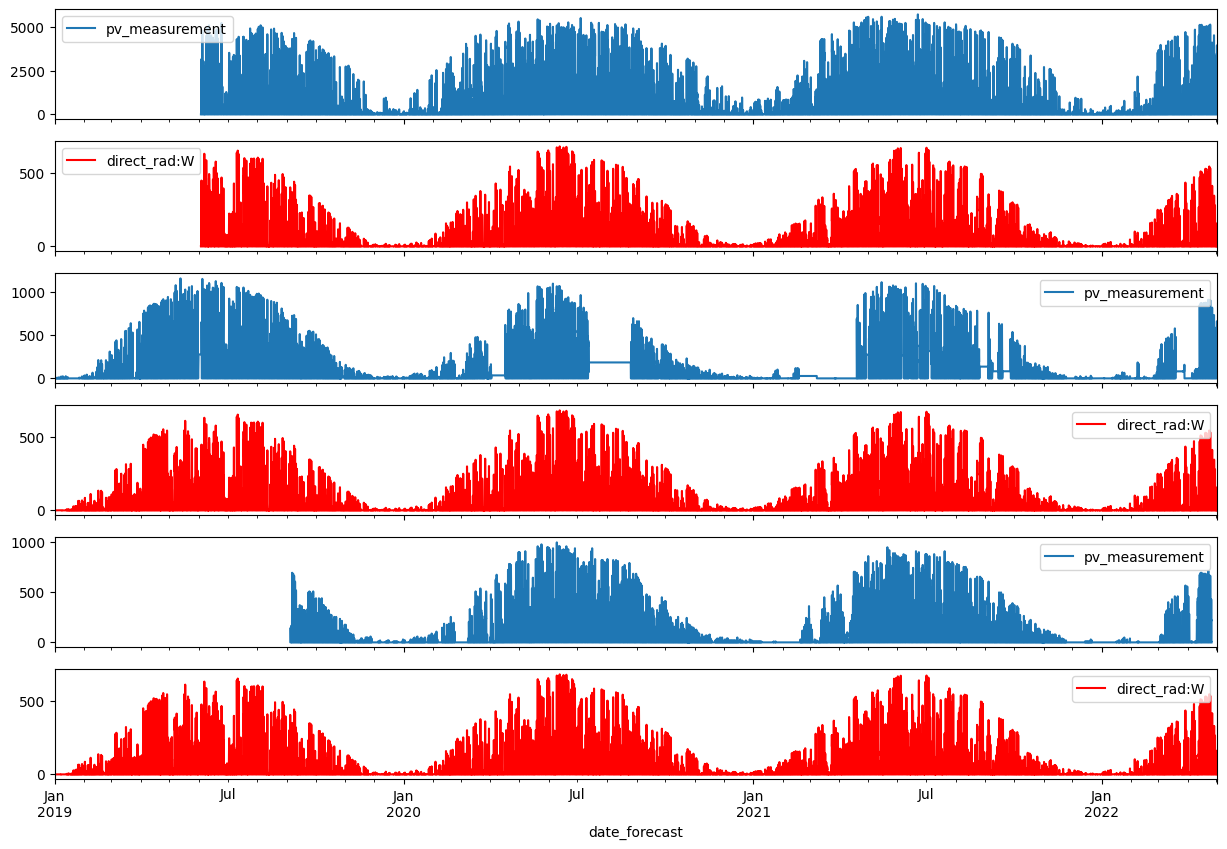

In [80]:
### generalized plotting
start_date = '2019'
end_date = '2024'

feature_name = "direct_rad:W"

Y = [targets_a, targets_b, targets_c,]
X = [X_train_observed_a, X_train_observed_b, X_train_observed_c,]

plot_ts1(y=Y, 
              x=X, 
              feature=feature_name, 
              start=start_date, 
              end=end_date, 
              shareX=True)

### Preprocessing and Feature Engineering 

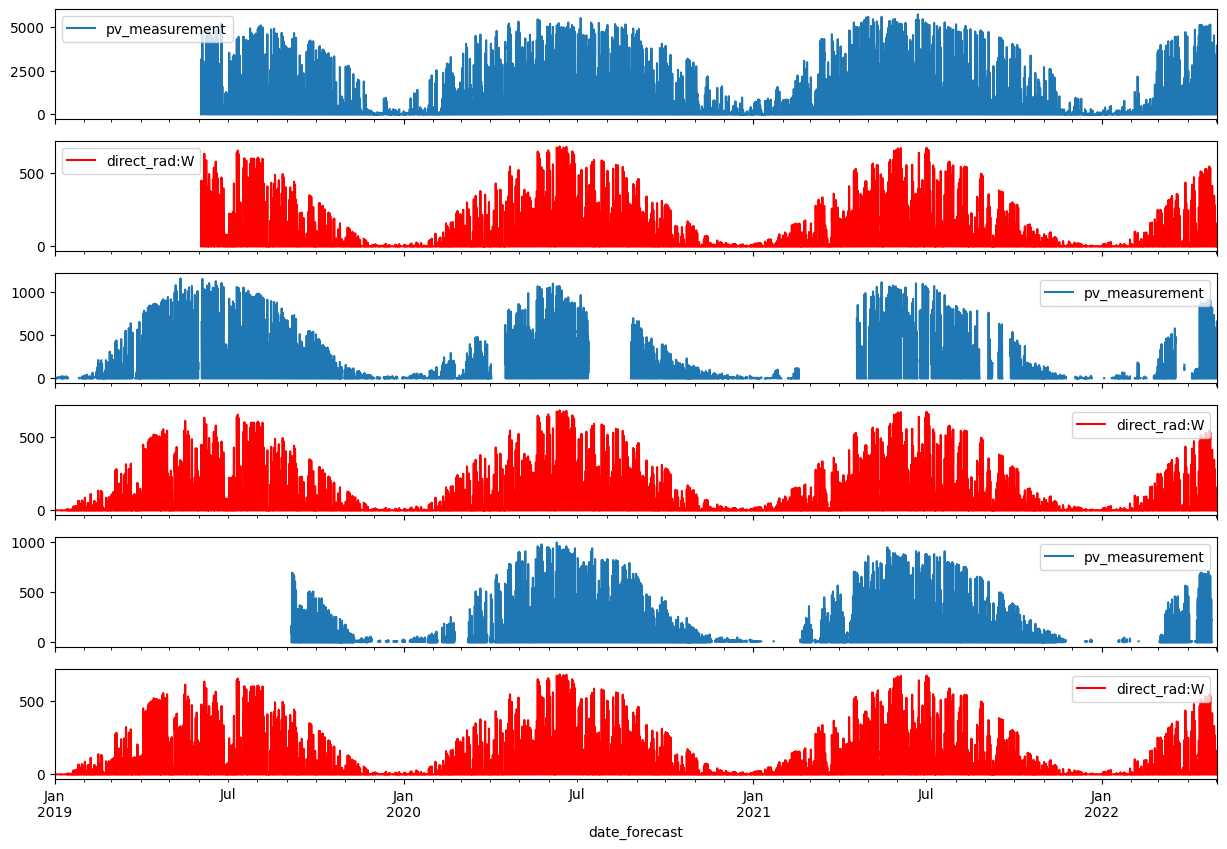

In [81]:
# removing rows where pv_measurment remains the same for more than 18 hours.
targets_a = remove_constant_values(targets_a, "pv_measurement", 18).dropna()
targets_b = remove_constant_values(targets_b, "pv_measurement", 18).dropna()
targets_c = remove_constant_values(targets_c, "pv_measurement", 18).dropna()

Y = [targets_a, targets_b, targets_c]
X = [X_train_observed_a, X_train_observed_b, X_train_observed_c, ]

start_date = '2019'
end_date = '2024'
feature_name = "direct_rad:W"

plot_ts1(y=Y, 
              x=X, 
              feature=feature_name, 
              start=start_date, 
              end=end_date, 
              shareX=True)

In [82]:
def create_features(df):
    new_df = df.copy()
    new_df['hour'] = new_df.index.hour
    new_df['dayofweek'] = new_df.index.dayofweek
    new_df['quarter'] = new_df.index.quarter
    new_df['month'] = new_df.index.month
    new_df['year'] = new_df.index.year
    new_df['dayofyear'] = new_df.index.dayofyear
    new_df['dayofmonth'] = new_df.index.day
    new_df['weekofyear'] = new_df.index.isocalendar().week
    return new_df

In [83]:
### Adding more time based features to the datasets
X_train_observed_a = create_features(X_train_observed_a)
X_train_observed_b = create_features(X_train_observed_b)
X_train_observed_c = create_features(X_train_observed_c)

X_train_estimated_a = create_features(X_train_estimated_a)
X_train_estimated_b = create_features(X_train_estimated_b)
X_train_estimated_c = create_features(X_train_estimated_c)

X_test_estimated_a = create_features(X_test_estimated_a)
X_test_estimated_b = create_features(X_test_estimated_b)
X_test_estimated_c = create_features(X_test_estimated_c)

In [84]:
### Using only observed weather for training
# Join the y values into x-dataframes for training
train_a = pd.merge(X_train_observed_a, targets_a, left_index=True, right_index=True)
train_b = pd.merge(X_train_observed_b, targets_b, left_index=True, right_index=True)
train_c = pd.merge(X_train_observed_c, targets_c, left_index=True, right_index=True)

In [85]:
# # Check which features most correlated with y
# correlations = train_a.corrwith(train_a["pv_measurement"])
# for index, corr in correlations.items():
#     correlations[index] = abs(corr)

# sorted = correlations.sort_values(ascending=False)
# best_features = list(sorted[1:10].index)
# print(best_features)

### Creating The Model

#### Select Features

In [86]:
# Step 1: Create the full list of features
FEATURES = list(train_a.columns[:-1])  # Using all the features of X.
TARGETS = "pv_measurement"

### DATA
X_a = train_a[FEATURES]
y_a = train_a[TARGETS]

X_b = train_b[FEATURES]
y_b = train_b[TARGETS]

X_c = train_c[FEATURES]
y_c = train_c[TARGETS]

#### Hyperparameter tuning

In [87]:
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameters and their possible values
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 10],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'n_estimators': [100, 200, 500, 1000],
    'gamma': [0, 0.25, 0.5, 1.0],
    'min_child_weight': [1, 2, 3, 4]
}

# Initialize XGBRegressor
reg = xgb.XGBRegressor()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    reg, 
    param_distributions=param_dist, 
    n_iter=100, 
    scoring='neg_mean_absolute_error', 
    verbose=1, 
    cv=3, 
    n_jobs=-1
)

# Fit the model
# random_search.fit(X_train_a, y_train_a)
# random_search.fit(X_train_b, y_train_b)
# random_search.fit(X_train_c, y_train_c)

# Print the best parameters
# print(random_search.best_params_)


In [88]:
default_params = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'early_stopping_rounds': 100,
    'objective': 'reg:absoluteerror'
}

best_params_a = {'subsample': 0.9, 
               'n_estimators': 1000, 
               'min_child_weight': 3, 
               'max_depth': 8, 
               'learning_rate': 0.05, 
               'gamma': 0.25, 
               'colsample_bytree': 0.5,
               'objective': 'reg:absoluteerror',
               'early_stopping_rounds': 10}

best_params_bc = {'subsample': 0.7, 
                  'n_estimators': 1000,
                  'min_child_weight': 3, 
                  'max_depth': 7, 
                  'learning_rate': 0.05, 
                  'gamma': 0.5, 
                  'colsample_bytree': 0.5,
                  'objective': 'reg:absoluteerror',
                  'early_stopping_rounds': 10}

#### Train/Test split

In [89]:
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size=0.2, random_state=42)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, random_state=42)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=42)

#### Location A

In [90]:
### Location A

# Create an XGBoostRegressor with some default hyperparameters
reg_A = xgb.XGBRegressor(**best_params_a)

# Fit the model on the training data
reg_A.fit(X_train_a, y_train_a,
        eval_set = [(X_train_a, y_train_a), (X_test_a, y_test_a)],
        verbose=100)

# Make predictions on the test data
y_pred_a = reg_A.predict(X_test_a)

y_pred_a = np.clip(y_pred_a, a_min=0, a_max=None)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_a, y_pred_a)

print(f"Mean Absolute Error: {mae}")

[0]	validation_0-mae:691.21080	validation_1-mae:694.41147


[100]	validation_0-mae:182.05363	validation_1-mae:209.58717
[200]	validation_0-mae:171.13385	validation_1-mae:205.96684
[300]	validation_0-mae:165.64363	validation_1-mae:204.91279
[400]	validation_0-mae:159.92182	validation_1-mae:203.79295
[500]	validation_0-mae:152.68501	validation_1-mae:202.44052
[600]	validation_0-mae:147.91684	validation_1-mae:201.61271
[632]	validation_0-mae:146.27951	validation_1-mae:201.54701
Mean Absolute Error: 201.26098237829441


#### Location B

In [91]:
### Location B

# Create an XGBoostRegressor with some default hyperparameters
reg_B = xgb.XGBRegressor(**best_params_bc)

# Fit the model on the training data
reg_B.fit(X_train_b, y_train_b,
        eval_set = [(X_train_b, y_train_b), (X_test_b, y_test_b)],
        verbose=100)

# Make predictions on the test data
y_pred_b = reg_B.predict(X_test_b)

y_pred_b = np.clip(y_pred_b, a_min=0, a_max=None)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_b, y_pred_b)

print(f"Mean Absolute Error: {mae}")

[0]	validation_0-mae:131.89675	validation_1-mae:129.85528
[100]	validation_0-mae:30.13206	validation_1-mae:34.98175
[200]	validation_0-mae:28.07697	validation_1-mae:33.97979
[300]	validation_0-mae:26.99470	validation_1-mae:33.59078
[400]	validation_0-mae:25.99249	validation_1-mae:33.33714
[500]	validation_0-mae:24.87487	validation_1-mae:33.09338
[501]	validation_0-mae:24.87187	validation_1-mae:33.09384
Mean Absolute Error: 33.02874130249493


#### Location C

In [92]:
### Location C

# Create an XGBoostRegressor with some default hyperparameters
reg_C = xgb.XGBRegressor(**best_params_bc)

# Fit the model on the training data
reg_C.fit(X_train_c, y_train_c,
        eval_set = [(X_train_c, y_train_c), (X_test_c, y_test_c)],
        verbose=100)

# Make predictions on the test data
y_pred_c = reg_C.predict(X_test_c)

y_pred_c = np.clip(y_pred_c, a_min=0, a_max=None)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_c, y_pred_c)

print(f"Mean Absolute Error: {mae}")

[0]	validation_0-mae:114.22798	validation_1-mae:108.45796
[100]	validation_0-mae:25.45492	validation_1-mae:29.82747
[200]	validation_0-mae:23.34291	validation_1-mae:28.98700
[300]	validation_0-mae:21.85810	validation_1-mae:28.52779
[400]	validation_0-mae:20.94153	validation_1-mae:28.29725
[411]	validation_0-mae:20.79551	validation_1-mae:28.30577
Mean Absolute Error: 28.251701462099387


### Model Interpretation

#### Feature Importance

In [93]:
fi_a = pd.DataFrame(data=reg_A.feature_importances_,
             index=reg_A.feature_names_in_,
             columns=["importance"])
fi_a.sort_values("importance", ascending=False).head(100)

,importance
is_in_shadow:idx,0.504638
is_day:idx,0.309516
sun_elevation:d,0.035886
diffuse_rad:W,0.035104
clear_sky_rad:W,0.018289
clear_sky_energy_1h:J,0.011401
direct_rad:W,0.009810
diffuse_rad_1h:J,0.009546
hour,0.007797
sun_azimuth:d,0.004148


In [94]:
fi_b = pd.DataFrame(data=reg_B.feature_importances_,
             index=reg_B.feature_names_in_,
             columns=["importance"])
fi_b.sort_values("importance", ascending=False).head()

,importance
is_day:idx,0.339205
is_in_shadow:idx,0.270391
sun_elevation:d,0.077280
diffuse_rad:W,0.056909
clear_sky_rad:W,0.053326


In [95]:
fi_c = pd.DataFrame(data=reg_C.feature_importances_,
             index=reg_C.feature_names_in_,
             columns=["importance"])
fi_c.sort_values("importance", ascending=False).head()

,importance
is_in_shadow:idx,0.355534
is_day:idx,0.312517
sun_elevation:d,0.067676
diffuse_rad:W,0.048019
clear_sky_rad:W,0.036494


#### Visualizing the validation sets

<Axes: >

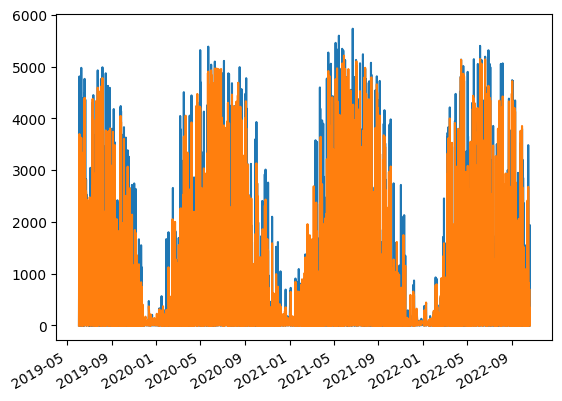

In [96]:
y_test_a.plot()
X_test_a["prediction"] = y_pred_a
X_test_a["prediction"].plot()

<Axes: >

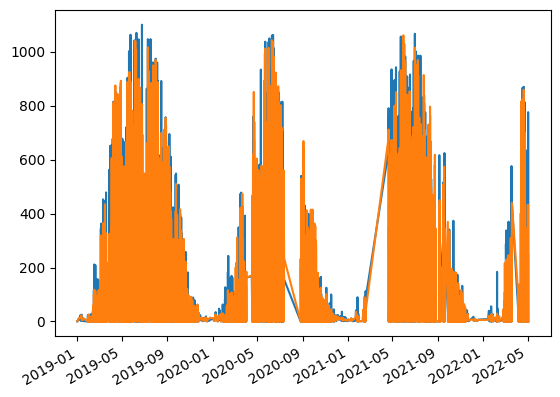

In [97]:
y_test_b.plot()
X_test_b["prediction"] = y_pred_b
X_test_b["prediction"].plot()

<Axes: >

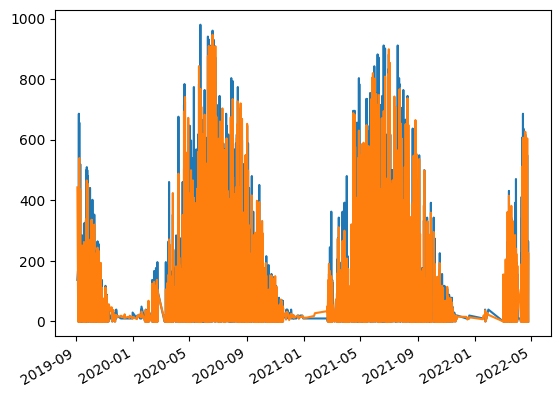

In [98]:
y_test_c.plot()
X_test_c["prediction"] = y_pred_c
X_test_c["prediction"].plot()

#### Using the weather forecast part of the training data as a dummy unseen test set

2023-04-28 11:00:00    3715.834102
2023-04-28 12:00:00    3277.296777
2023-04-28 10:00:00    2968.159395
2023-03-20 11:00:00    2755.084644
2023-04-16 08:00:00    2626.996035
Name: error, dtype: float64

Mean Absolute Error: 130.28787609980532
MAE for the last 1000 values: 259.69411408369376


<Axes: >

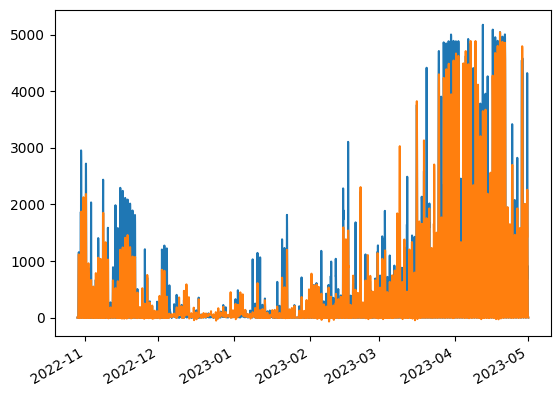

In [99]:
df = X_train_estimated_a[FEATURES]
df["prediction"] = reg_A.predict(X_train_estimated_a[FEATURES])

df = pd.merge(df, targets_a, left_index=True, right_index=True)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

print(f"Mean Absolute Error: {mae}")

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot() 

2023-04-28 11:00:00    607.852685
2023-04-30 12:00:00    553.483125
2023-04-28 12:00:00    521.540354
2023-04-08 11:00:00    487.075409
2023-04-28 10:00:00    430.489260
Name: error, dtype: float64

Mean Absolute Error: 18.884002676185307
MAE for the last 1000 values: 38.95737760356431


<Axes: >

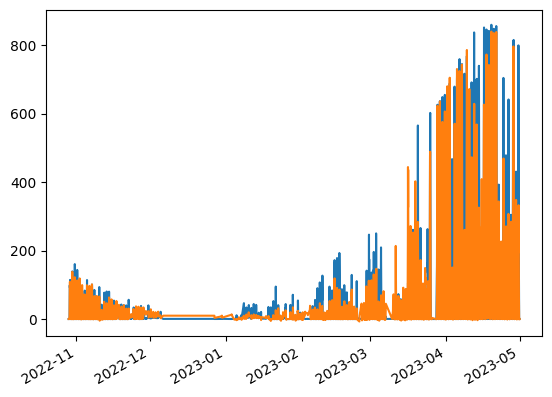

In [100]:
df = X_train_estimated_b[FEATURES]
df["prediction"] = reg_B.predict(X_train_estimated_b[FEATURES])

df = pd.merge(df, targets_b, left_index=True, right_index=True)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)

print(f"Mean Absolute Error: {mae}")

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot()

2023-03-27 11:00:00    415.190513
2023-03-27 12:00:00    408.092972
2023-03-27 13:00:00    345.272085
2023-03-19 10:00:00    338.731271
2023-03-27 10:00:00    334.961707
Name: error, dtype: float64

Mean Absolute Error: 26.35341992493302
MAE for the last 1000 values: 47.81330632484229


<Axes: >

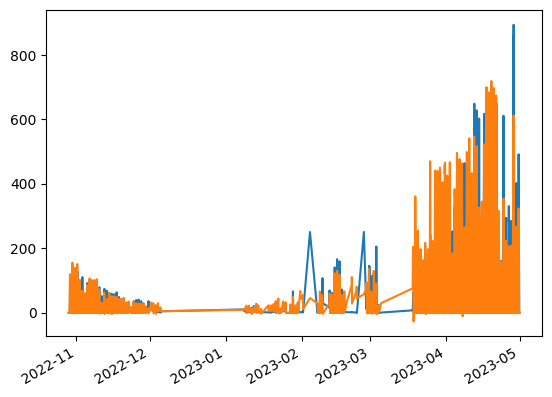

In [101]:
df = X_train_estimated_c[FEATURES]
df["prediction"] = reg_C.predict(X_train_estimated_c[FEATURES])

df = pd.merge(df, targets_c, left_index=True, right_index=True)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])
print(f"Mean Absolute Error: {mae}")

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot()


### Predicting On The Actual Kaggle Set

In [102]:
### Location A
X_test_estimated_a = X_test_estimated_a[FEATURES]
A_pred = reg_A.predict(X_test_estimated_a)
A_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(A_pred), 4):
    A_pred_hourly.append(A_pred[i])
    

In [103]:
### Location B
X_test_estimated_b = X_test_estimated_b[FEATURES]
B_pred = reg_B.predict(X_test_estimated_b)
B_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(B_pred), 4):
    B_pred_hourly.append(B_pred[i])

In [104]:
   
### Location C
X_test_estimated_c = X_test_estimated_c[FEATURES]
C_pred = reg_C.predict(X_test_estimated_c)
C_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(C_pred), 4):
    C_pred_hourly.append(C_pred[i])  

#### Visualizing how the model predicts on the actual test set

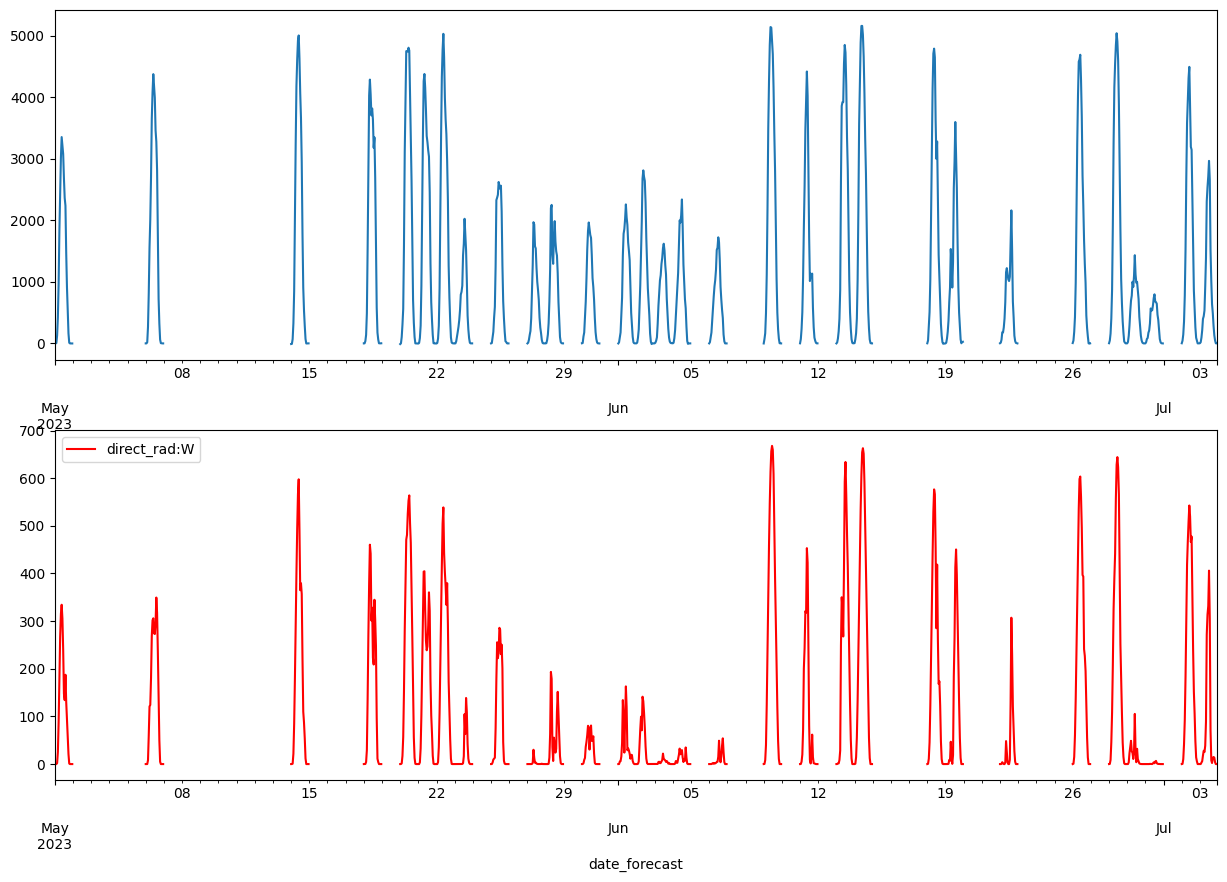

In [105]:
df = X_test_estimated_a.copy()
df["prediction"] = reg_A.predict(X_test_estimated_a[FEATURES])

start = "05-2023"
end = "08-2023"
feature = "direct_rad:W"

plot_ts1([df["prediction"]], [df], start, end, feature, shareX=False)



#### Storing the predictions

In [106]:
predictions = np.concatenate([A_pred_hourly, B_pred_hourly, C_pred_hourly])
# remove negative and small positive predictions
predictions = np.where(predictions < 0.05, 0, predictions)
ids = range(len(predictions))
df = pd.DataFrame({"id": ids, "prediction": predictions})
df.to_csv("xgboost.csv", index=False)

# AutoGluon

The model that gave us the best results was the AutoML model AutoGluon, which combines a bunch of traditional tree-based algorithms, in addition to neural networks and clustering algorithms. We have tried many different combinations of all the things we mentioned under Data Preprocessing, Feature Engineering and Model Training. We will provide a brief overview in text, and also some code for each location.

### Data Preprocessing

Similarly to the XGBoost model, we used some functions to plot different features and the target value up against each other. See "Helper functions." We also used the remove_constant_values() functions to remove rows where the target variable remained constant for different user specified thresholds, while also dropping NaN values.

We also tried normalizing all the X features, but that led to worse results.

#### Helper functions

In [ ]:
def plot_ts(y: pd.DataFrame, x:pd.DataFrame, start, end, feature, shareX: bool):
    """
    Plots all the y arrays, then all the x arrays.
    """
    fig, axs = plt.subplots(len(x)+len(y), 1, figsize=(15,10), sharex=shareX)
    i = 0
    for df in y:
        df[(df.index >= start) & (df.index <= end)].resample("H").mean().plot(ax=axs[i])
        i += 1
    
    for df in x:
        df[(df.index >= start) & (df.index <= end)].resample("H").mean()[feature].plot(ax=axs[i], label=feature, color="red")
        axs[i].legend()
        i += 1
    
            
def plot_ts1(y: pd.DataFrame, x:pd.DataFrame, start, end, feature, shareX: bool):
    """
    Plots the y and x values directly under each other for each location
    """
    
    if len(x) != len(y):
        print("Error: arrays 'y' and 'x' are different lengths. Please provide equal sized arrays.")
    else:
        fig, axs = plt.subplots(len(x)+len(y), 1, figsize=(15,10), sharex=shareX)
        i = 0
        for df_y, df_x in zip(y, x):
                df_y[(df_y.index >= start) & (df_y.index <= end)].resample("H").mean().plot(ax=axs[i])
                i += 1
                df_x[(df_x.index >= start) & (df_x.index <= end)].resample("H").mean()[feature].plot(ax=axs[i], label=feature, color="red")
                axs[i].legend()
                i += 1
  

def remove_constant_values(df, column_name, threshold):
    
    new_df = df.copy()

    # Find the consecutive constant rows
    consecutive_constants = new_df.groupby((new_df[column_name] != new_df[column_name].shift()).cumsum()).filter(lambda x: len(x) > threshold)

    # Filter out the consecutive constant rows from the original DataFrame
    filtered_df = new_df[~new_df.index.isin(consecutive_constants.index)]
    
    return filtered_df


### Feature Engineering

We have tried the following. Please see the example code for Location A:
- adding time based features such as hour, day, month etc.
- encoding those features as sine and cosine functions.
- taking the mean of the 15 min interval features of each hourly period and using that as the hourly value.
- marking wrong type features as correct type, eg. snow_drift:idx and other index features as "category" or "int" instead of float.
- for each whole hour datapoint such as 15:00, append the 15:15, 15:30, and 15:45 values to that datapoint.
- dropping various features based on either feature importance, intution, or lots of missing values.

### Model Training

We experimented with:
- Using only observed weather for training and validation
- Using all estimated weather as validation set
- Using some estimated weather in training, some in validation.
- Various splits for what part of estimated weather we used in validation set.
    Either split in at a given date, or sample random datapoints. When using random sample - we tried different percentages for how much of the estimated weather to use in validation, and also different random seeds.
- We tried different presets in AutoGluon. For location A and B 'best quality' performed best. But for C our best model is still with no preset, ie. 'medium' quality.

### Model Interpretation

- We used autogluons leaderboard function to see which single model or ensemble model performed best.
- We also used the feature importance function to see how important different features were, and removing the ones with negative score.
- We plotted the models predicitons against the ground truth and also calculated the MAE for a local test set before submitting to Kaggle.
- Calculated the biggest errors on local test set to possibly identify a pattern on where the model was missing.

### Conclusion

In the end, we experimented with a multitude of combinations of preprocessing, feature engineering, train/val splits and model parameters. The best result used minimum feature engineering, best quality model, and a random sample of estimated weather as validation set for location A. For B, we used the same as A except simply the 50% first datapoints of estimated weather as validation data. For C, we removed a majority of the features, medium model quality and used the 50% first datapoints of estiamted weather as validation data. Please note that all the preproccesing can be studied in the short notebook. The code here does not necessarily contain all the things we have described in the text, but is meant as an example of most of it.

## Example code for Location A

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
import numpy as np
import utils4
from sklearn.metrics import mean_absolute_error

### Reading in files and indexing them on time

In [ ]:
targets_a = TabularDataset('../data/A/train_targets.parquet')
targets_a = targets_a.set_index('time')

Loaded data from: ../data/A/train_targets.parquet | Columns = 2 / 2 | Rows = 34085 -> 34085


In [ ]:
X_train_observed_a = TabularDataset('../data/A/X_train_observed.parquet')
X_train_observed_a = X_train_observed_a.set_index("date_forecast")

Loaded data from: ../data/A/X_train_observed.parquet | Columns = 46 / 46 | Rows = 118669 -> 118669


In [ ]:
X_train_estimated_a = TabularDataset('../data/A/X_train_estimated.parquet')
X_train_estimated_a = X_train_estimated_a.set_index("date_forecast")

Loaded data from: ../data/A/X_train_estimated.parquet | Columns = 47 / 47 | Rows = 17576 -> 17576


In [ ]:
X_test_estimated_a = TabularDataset('../data/A/X_test_estimated.parquet')
X_test_estimated_a = X_test_estimated_a.set_index("date_forecast")

Loaded data from: ../data/A/X_test_estimated.parquet | Columns = 47 / 47 | Rows = 2880 -> 2880


### Data Preprocessing

In [ ]:
# removing rows where pv_measurment remains the same for more than 18 hours.
targets_a = utils4.remove_constant_values(targets_a, "pv_measurement", 18).dropna()

In [ ]:
### Sin/cos stuff. performed worse than not doing it
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [ ]:
def create_features(df):
    new_df = df.copy()
    new_df['hour'] = new_df.index.hour
    # encode(new_df, 'hour', 24.0)
    # new_df = new_df.drop(columns=['hour'])
    
    # new_df['dayofweek'] = new_df.index.dayofweek
    # new_df['quarter'] = new_df.index.quarter
    new_df['month'] = new_df.index.month
    # encode(new_df, 'month', 12.0)
    # new_df = new_df.drop(columns=['month'])
    
    # new_df['year'] = new_df.index.year
    # new_df['dayofyear'] = new_df.index.dayofyear
    # encode(new_df, 'dayofyear', 365.0)
    # new_df = new_df.drop(columns=['dayofyear'])
    # new_df['dayofmonth'] = new_df.index.day
    # new_df['weekofyear'] = new_df.index.isocalendar().week.astype(int)
    return new_df

In [ ]:
### Adding more time based features to the datasets
X_train_observed_a = create_features(X_train_observed_a)

X_train_estimated_a = create_features(X_train_estimated_a)

X_test_estimated_a = create_features(X_test_estimated_a)

In [ ]:
### Generally got worse performance when using this function.
def mark_correct_type(df):
    df['snow_drift:idx'] = df['snow_drift:idx'].astype("category")
    df['snow_density:kgm3'] = df['snow_density:kgm3'].astype("float")
    df['precip_type_5min:idx'] = df['precip_type_5min:idx'].astype("category")
    df['dew_or_rime:idx'] = df['dew_or_rime:idx'].astype("category")
    return df

In [ ]:
# X_train_observed_a = mark_correct_type(X_train_observed_a)

# X_train_estimated_a = mark_correct_type(X_train_estimated_a)

# X_test_estimated_a = mark_correct_type(X_test_estimated_a)

In [ ]:
def add_15min_fts(df, columns):
    for column in columns:
        # df[column+'-15'] = df[column].shift(1)
        df[column+'15'] = df[column].shift(-1)
        df[column+'30'] = df[column].shift(-2)
        df[column+'45'] = df[column].shift(-3)
    return df

In [ ]:
### Input columns you want to add 15 min features for here:
columns = [ 

]

In [ ]:

X_train_observed_a = add_15min_fts(X_train_observed_a, columns=columns)

X_train_estimated_a = add_15min_fts(X_train_estimated_a, columns=columns)

X_test_estimated_a = add_15min_fts(X_test_estimated_a, columns=columns)

In [ ]:
### Using only observed weather for training
# Join the y values into x-dataframes for training
train_a = pd.merge(X_train_observed_a, targets_a, left_index=True, right_index=True)

In [ ]:
### Using estimated weather for validation and local testing
# Join the y values into x-dataframes 
test_a = pd.merge(X_train_estimated_a, targets_a, left_index=True, right_index=True)

In [ ]:
# Remove 'date_calc' from test set and kaggle set
test_a.drop(columns=['date_calc'], inplace=True)
X_test_estimated_a.drop(columns=['date_calc'], inplace=True)

In [ ]:
# List of column names to drop
columns_to_drop = [
    # 'snow_density:kgm3',
    'snow_drift:idx',
    'elevation:m',                    

    
    # 'rain_water:kgm2',
    # 'cloud_base_agl:m',
    # 'air_density_2m:kgm3',
    # 'is_in_shadow:idx',
    # 'pressure_50m:hPa',
    # 'visibility:m',
    # 'wind_speed_w_1000hPa:ms',
    # 'ceiling_height_agl:m',
    # 'snow_melt_10min:mm',
    # 't_1000hPa:K',
    
]

# Drop the specified columns from the DataFrames
train_a = train_a.drop(columns=columns_to_drop)

test_a = test_a.drop(columns=columns_to_drop)

X_test_estimated_a = X_test_estimated_a.drop(columns=columns_to_drop)

#### Normalize (unused)

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# # Assuming 'pv_measurement' is the target variable
# target_train = train_a['pv_measurement']
# target_test = test_a['pv_measurement']

# train_a = train_a.drop(columns=['pv_measurement'])
# test_a = test_a.drop(columns=['pv_measurement'])

# # Initialize the MinMaxScaler for features
# scaler_tr = MinMaxScaler()
# scaler_te = MinMaxScaler()
# scaler_kg = MinMaxScaler()

# # Fit and transform the scalers on the original data for features
# norm_train = scaler_tr.fit_transform(train_a)
# norm_test = scaler_te.fit_transform(test_a)
# norm_kaggle = scaler_kg.fit_transform(X_test_estimated_a)

# # Create new DataFrames with the normalized features
# train_a = pd.DataFrame(norm_train, index=train_a.index, columns=train_a.columns)
# test_a = pd.DataFrame(norm_test, index=test_a.index, columns=test_a.columns)
# X_test_estimated_a = pd.DataFrame(norm_kaggle, index=X_test_estimated_a.index, columns=X_test_estimated_a.columns)

# # Concatenate the target variable back to the DataFrame
# train_a['pv_measurement'] = target_train
# test_a['pv_measurement'] = target_test

#### Some different functions for making tha val/test split

In [ ]:
def split(df):
    midpoint = len(df)//2
    front = df.iloc[:midpoint]
    end = df.iloc[midpoint:]
    return front, end

def split1000(df):
    front = df.iloc[:-1000]
    end = df.iloc[-1000:]
    return front, end

def sample_days(df, testfrac=0.5):
    # Extract unique dates from the datetime index as a list of date objects
    unique_dates = np.unique(df.index.date)
    
    combined_dates = []
    
    # Iterate through the unique dates and add all hours for each date
    for date in unique_dates:
        hours_for_date = df[df.index.date == date].index
        
        ### Only where all 24 hours are present for a date:
        if len(hours_for_date) == 24:
            combined_dates.append(hours_for_date)
    
    one = pd.Series(combined_dates).sample(frac=testfrac, random_state=42)
    two = pd.Series(combined_dates)[~pd.Series(combined_dates).isin(one)]
    
    #flatten the series and filter the dataframes on those series
    test = df[df.index.isin(one.explode())]
    val = df[df.index.isin(two.explode())]
    
    return val, test


In [ ]:
def sample_days_org(df, testfrac=0.6):
    # Extract unique dates from the datetime index as a list of date objects
    unique_dates = np.unique(df.index.date)
    
    combined_dates = []
    
    # Iterate through the unique dates and add all hours for each date
    for date in unique_dates:
        hours_for_date = df[df.index.date == date].index.time
        
        ## If you want all datapoints:
        combined_dates.extend([pd.Timestamp(date) + pd.DateOffset(hours=hour.hour) for hour in hours_for_date])
        
        ### Only where all 24 hours are present for a date:
        # if len(hours_for_date) == 24:
            # combined_dates.extend([pd.Timestamp(date) + pd.DateOffset(hours=hour.hour) for hour in hours_for_date])
    
    one = pd.Series(combined_dates).sample(frac=testfrac, random_state=35)
    two = pd.Series(combined_dates)[~pd.Series(combined_dates).isin(one)]
    
    test = df[df.index.isin(one)]
    val = df[df.index.isin(two)]
    
    return val, test

In [ ]:
### Throw in some estimated weather to training as validation set, and the rest for testing
val_a, test_a = sample_days_org(test_a)

In [ ]:
### Ensure a strict separation of validation and test set
def all_indices_different(df1, df2):
    # Check if all indices are different
    return df1.index.intersection(df2.index).empty

all_indices_different(val_a, test_a)

True

In [ ]:
print(val_a.shape[0])
print(test_a.shape[0])

1510
2264


### Create our model

### Location A

In [ ]:
predictor_a = TabularPredictor(label='pv_measurement', eval_metric='mean_absolute_error').fit(train_data=train_a,
                                                                                            tuning_data=val_a, 
                                                                                            presets='best_quality',
                                                                                            use_bag_holdout=True,
                                                                                            # # num_bag_folds=5, 
                                                                                            # # num_bag_sets=1, 
                                                                                            # # num_stack_levels=3,
                                                                                            # excluded_model_types=excluded_model_types.
                                                                                            )

No path specified. Models will be saved in: "AutogluonModels\ag-20231107_132123\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20231107_132123\"
AutoGluon Version:  0.8.2
Python Version:     3.10.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   304.81 GB / 510.77 GB (59.7%)
Train Data Rows:    27741
Train Data Columns: 45
Tuning Data Rows:    1510
Tuning Data Columns: 45
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, 0.0, 720.95004, 1222.61515)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting 

In [ ]:
predictor_a.leaderboard(test_a, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-133.330045,-119.256314,0.168396,0.052242,57.323130,0.011554,0.015609,0.224625,2,True,12
1,NeuralNetTorch,-136.313531,-122.433843,0.053982,0.015626,31.543164,0.053982,0.015626,31.543164,1,True,10
2,LightGBMLarge,-143.568897,-131.864143,0.037084,0.008011,2.215507,0.037084,0.008011,2.215507,1,True,11
3,LightGBM,-144.893135,-135.440456,0.019290,0.009837,1.316595,0.019290,0.009837,1.316595,1,True,4
4,LightGBMXT,-145.594922,-136.840288,0.025731,0.015005,1.839911,0.025731,0.015005,1.839911,1,True,3
5,XGBoost,-146.775981,-137.320918,0.020278,0.000000,1.161479,0.020278,0.000000,1.161479,1,True,9
6,ExtraTreesMSE,-149.208637,-141.284006,0.464661,0.063773,7.234563,0.464661,0.063773,7.234563,1,True,7
7,RandomForestMSE,-153.952516,-140.829775,0.406633,0.047282,37.810159,0.406633,0.047282,37.810159,1,True,5
8,CatBoost,-155.717027,-144.564618,0.032262,0.000000,12.270421,0.032262,0.000000,12.270421,1,True,6
9,NeuralNetFastAI,-160.951131,-148.181303,0.065776,0.012997,23.339834,0.065776,0.012997,23.339834,1,True,8


#### Feature importance, takes long time to run when using best quality

In [ ]:

pd.set_option('display.max_rows', None)
# predictor_a.feature_importance(test_a,)

#### load different models below

In [ ]:
# predictor_a = TabularPredictor.load('AutogluonModels/best_a')

#### Using the weather forecast part of the training data as a dummy unseen test set

2023-04-28 11:00:00    3763.150508
2023-03-23 13:00:00    3491.387969
2023-04-28 10:00:00    2997.825898
2023-03-20 11:00:00    2920.089893
2023-03-23 14:00:00    2653.800957
Name: error, dtype: float64

Mean Absolute Error: 134.52730968087266
MAE for the last 1000 values: 217.21115600643785


<AxesSubplot: >

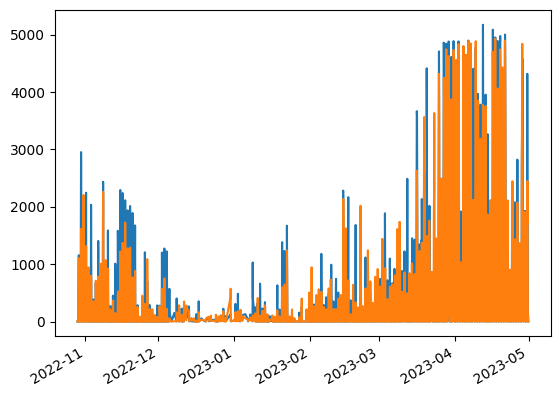

In [ ]:
df = test_a.copy()
a_pred = predictor_a.predict(test_a)
a_pred = np.where(a_pred < 0.05, 0, a_pred)
df["prediction"] = a_pred

# org_data = scaler_te.inverse_transform(df)
# df = pd.DataFrame(org_data, index=df.index, columns=df.columns)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

print(f"Mean Absolute Error: {mae}")

last_1000_values_df = df.tail(1000)

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)


df["pv_measurement"].plot()
df["prediction"].plot() 

# display(df.sort_values('error', ascending=False))

#### Correlation with error

In [ ]:
# c_test = df.corrwith(df['error'])
# for index, value in c_test.items():
#     c_test[index] = (value)
    
# print(c_test.sort_values(ascending=False))

#### Testing What Mistakes It Makes on tuning data

2023-04-28 12:00:00    3314.054590
2023-04-16 08:00:00    2848.896426
2023-03-23 10:00:00    2804.050000
2023-04-28 14:00:00    2381.886445
2023-03-26 09:00:00    2374.341899
Name: error, dtype: float64

Mean Absolute Error: 117.57510143488862
MAE for the last 1000 values: 141.44318018238886


<AxesSubplot: >

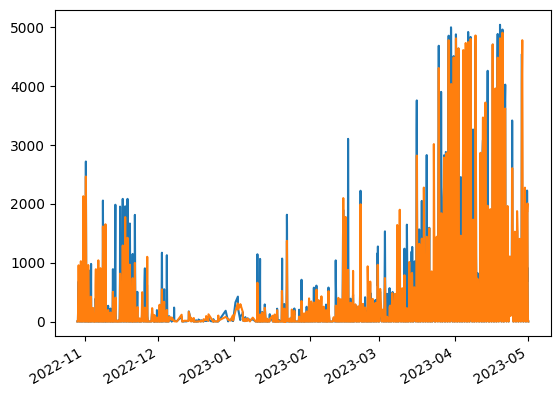

In [ ]:
df = val_a.copy()
a_pred = predictor_a.predict(val_a)
a_pred = np.where(a_pred < 0.05, 0, a_pred)
df["prediction"] = a_pred


df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

print(f"Mean Absolute Error: {mae}")

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot() 

# display(df.sort_values('error', ascending=False))

### Predicting on the actual test set

In [ ]:
### Location A
A_pred = predictor_a.predict(X_test_estimated_a)
A_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(A_pred), 4):
    A_pred_hourly.append(A_pred[i])

### Visualizing how the model predicts on the actual test set

In [ ]:
# df = X_test_estimated_a.copy()
# df["prediction"] = predictor_a.predict(X_test_estimated_a)

# start = "05-2023"
# end = "08-2023"
# feature = "direct_rad:W"

# utils4.plot_ts1([df["prediction"]], [df], start, end, feature, shareX=False)


### Storing the predictions

In [ ]:
predictions = np.array(A_pred_hourly)
# remove negative and small positive predictions
predictions = np.where(predictions < 0.05, 0, predictions)
ids = range(len(predictions))
df = pd.DataFrame({"id": ids, "prediction": predictions})
# df.to_csv("saves/A/autogluon_A.csv", index=False)

import os

directory = "saves/A/"
base_filename = "autogluon_A.csv"

# Find the next available number to append to the filename
i = 1
while True:
    filename = os.path.join(directory, f"{base_filename[:-4]}_{i}.csv")
    if not os.path.isfile(filename):
        break
    i += 1

# Save the DataFrame to the new filename
df.to_csv(filename, index=False)

## Example code for Location B

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
import numpy as np
import utils4
from sklearn.metrics import mean_absolute_error

### Reading in files and indexing them on time

In [ ]:
targets_b = TabularDataset('../data/B/train_targets.parquet')
targets_b = targets_b.set_index("time")

Loaded data from: ../data/B/train_targets.parquet | Columns = 2 / 2 | Rows = 32848 -> 32848


In [ ]:
X_train_observed_b = TabularDataset('../data/B/X_train_observed.parquet')
X_train_observed_b = X_train_observed_b.set_index("date_forecast")

Loaded data from: ../data/B/X_train_observed.parquet | Columns = 46 / 46 | Rows = 116929 -> 116929


In [ ]:
X_train_estimated_b = TabularDataset('../data/B/X_train_estimated.parquet')
X_train_estimated_b = X_train_estimated_b.set_index("date_forecast")

Loaded data from: ../data/B/X_train_estimated.parquet | Columns = 47 / 47 | Rows = 17576 -> 17576


In [ ]:
X_test_estimated_b = TabularDataset('../data/B/X_test_estimated.parquet')
X_test_estimated_b = X_test_estimated_b.set_index("date_forecast")

Loaded data from: ../data/B/X_test_estimated.parquet | Columns = 47 / 47 | Rows = 2880 -> 2880


### Data Preprocessing

In [ ]:
# removing rows where pv_measurment remains the same for more than 18 hours.
targets_b = utils4.remove_constant_values(targets_b, "pv_measurement", 18).dropna()

In [ ]:
def create_features(df):
    new_df = df.copy()
    new_df['hour'] = new_df.index.hour
    new_df['dayofweek'] = new_df.index.dayofweek
    new_df['quarter'] = new_df.index.quarter
    # new_df['month'] = new_df.index.month
    # # new_df['year'] = new_df.index.year
    # # new_df['dayofyear'] = new_df.index.dayofyear
    # # new_df['dayofmonth'] = new_df.index.day
    new_df['weekofyear'] = new_df.index.isocalendar().week.astype(int)
    return new_df

In [ ]:
### Adding more time based features to the datasets
X_train_observed_b = create_features(X_train_observed_b)

X_train_estimated_b = create_features(X_train_estimated_b)

X_test_estimated_b = create_features(X_test_estimated_b)

In [ ]:
def mark_correct_type(df):
    df['snow_drift:idx'] = df['snow_drift:idx'].astype("category")
    df['snow_density:kgm3'] = df['snow_density:kgm3'].astype("float")
    df['precip_type_5min:idx'] = df['precip_type_5min:idx'].astype("category")
    df['dew_or_rime:idx'] = df['dew_or_rime:idx'].astype("category")
    return df


In [ ]:
# X_train_observed_b = mark_correct_type(X_train_observed_b)

# X_train_estimated_b = mark_correct_type(X_train_estimated_b)

# X_test_estimated_b = mark_correct_type(X_test_estimated_b)

In [ ]:
def add_15min_fts(df, columns):
    for column in columns:
        df[column+'15'] = df[column].shift(-1)
        df[column+'30'] = df[column].shift(-2)
        df[column+'45'] = df[column].shift(-3)
    return df

In [ ]:
columns = [
#     'effective_cloud_cover:p',
# 'total_cloud_cover:p',
# 'wind_speed_u_10m:ms'
]

X_train_observed_b = add_15min_fts(X_train_observed_b, columns=columns)

X_train_estimated_b = add_15min_fts(X_train_estimated_b, columns=columns)

X_test_estimated_b = add_15min_fts(X_test_estimated_b, columns=columns)


In [ ]:
### Using only observed weather for training
# Join the y values into x-dataframes for training
train_b = pd.merge(X_train_observed_b, targets_b, left_index=True, right_index=True)

In [ ]:
### Using only observed weather for training
# Join the y values into x-dataframes for training
test_b = pd.merge(X_train_estimated_b, targets_b, left_index=True, right_index=True)

# Remove 'date_calc' from test set and kaggle set
test_b.drop(columns=['date_calc'], inplace=True)

X_test_estimated_b.drop(columns=['date_calc'], inplace=True)

In [ ]:
# List of column names to drop
columns_to_drop = [
  'elevation:m', 
  'snow_drift:idx',
  
  # 'air_density_2m:kgm3',
  # 'absolute_humidity_2m:gm3',
  # 'ceiling_height_agl:m',
  # 'dew_point_2m:K',
  # 'wind_speed_w_1000hPa:ms',
  # 'rain_water:kgm2',
  # 'visibility:m',
  # 'pressure_100m:hPa',
    ]

# Drop the specified columns from the DataFrames
train_b = train_b.drop(columns=columns_to_drop)

test_b = test_b.drop(columns=columns_to_drop)

X_test_estimated_b = X_test_estimated_b.drop(columns=columns_to_drop)

In [ ]:
def split(df):
    midpoint = len(df)//2
    front = df.iloc[:midpoint]
    end = df.iloc[midpoint:]
    return front, end

def split1000(df):
    midpoint = len(df)//2
    front = df.iloc[:-1000]
    end = df.iloc[-1000:]
    return front, end

def sample_days(df, testfrac=0.65):
    # Extract unique dates from the datetime index as a list of date objects
    unique_dates = np.unique(df.index.date)
    
    combined_dates = []
    
    # Iterate through the unique dates and add all hours for each date
    for date in unique_dates:
        hours_for_date = df[df.index.date == date].index.time
        
        ### If you want all datapoints:
        combined_dates.extend([pd.Timestamp(date) + pd.DateOffset(hours=hour.hour) for hour in hours_for_date])
        
        ### Only where all 24 hours are present for a date:
        # if len(hours_for_date) == 24:
        #     combined_dates.extend([pd.Timestamp(date) + pd.DateOffset(hours=hour.hour) for hour in hours_for_date])
    
    one = pd.Series(combined_dates).sample(frac=testfrac, random_state=35)
    two = pd.Series(combined_dates)[~pd.Series(combined_dates).isin(one)]
    
    test = df[df.index.isin(one)]
    val = df[df.index.isin(two)]
    
    return val, test


In [ ]:
# Throw in some estimated weather to training as validation set, and the rest for testing
val_b, test_b = split(test_b)

In [ ]:
val_b.shape[0]

1483

### Create our model

### Location B

In [ ]:
predictor_b = TabularPredictor(label='pv_measurement', eval_metric='mean_absolute_error').fit(train_b,
                                                                                            tuning_data=val_b, 
                                                                                            presets='best_quality',
                                                                                            use_bag_holdout=True,
                                                                                            # # num_bag_folds=5, 
                                                                                            # # num_bag_sets=1, 
                                                                                            # # num_stack_levels=3,
                                                                                            # excluded_model_types=excluded_model_types
                                                                                            )

No path specified. Models will be saved in: "AutogluonModels\ag-20231106_101217\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20231106_101217\"
AutoGluon Version:  0.8.2
Python Version:     3.10.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   289.91 GB / 510.77 GB (56.8%)
Train Data Rows:    18880
Train Data Columns: 47
Tuning Data Rows:    1483
Tuning Data Columns: 47
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1152.3, 0.0, 137.34504, 233.90588)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify

In [ ]:
predictor_b.leaderboard(test_b, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-30.739923,-4.925519,0.578011,1.363940,157.449291,0.001369,0.000000,0.188851,2,True,12
1,NeuralNetTorch_BAG_L1,-30.793319,-5.222282,0.201567,0.263900,116.717551,0.201567,0.263900,116.717551,1,True,10
2,WeightedEnsemble_L3,-30.930984,-5.164002,26.730568,471.643208,1555.257304,0.007334,0.015737,0.188922,3,True,22
3,NeuralNetTorch_BAG_L2,-30.961609,-5.188731,26.578066,471.222401,1521.636745,0.275955,0.344530,41.193211,2,True,20
4,LightGBMXT_BAG_L2,-31.365637,-5.228479,26.402289,471.173673,1486.205640,0.100178,0.295802,5.762105,2,True,13
5,CatBoost_BAG_L2,-31.496570,-5.538641,26.347102,470.987139,1508.113067,0.044991,0.109267,27.669532,2,True,16
6,LightGBM_BAG_L2,-31.828205,-5.582408,26.368676,471.085528,1486.397708,0.066565,0.207656,5.954173,2,True,14
7,ExtraTreesMSE_BAG_L2,-31.871228,-5.439681,26.654672,471.694758,1487.788009,0.352561,0.816886,7.344474,2,True,17
8,XGBoost_BAG_L2,-32.093277,-5.539678,26.418835,470.989492,1488.313019,0.116724,0.111621,7.869484,2,True,19
9,NeuralNetFastAI_BAG_L2,-32.106131,-6.233144,26.551802,471.263588,1513.141367,0.249691,0.385716,32.697833,2,True,18


In [ ]:
# predictor_b.feature_importance(test_b, num_shuffle_sets=5)

In [ ]:
# predictor_b = TabularPredictor.load('AutogluonModels/best_b')

#### Using the weather forecast part of the training data as a dummy unseen test set

2023-04-28 11:00:00    629.485558
2023-04-28 12:00:00    573.360850
2023-04-30 12:00:00    522.806352
2023-04-28 10:00:00    479.498965
2023-04-08 11:00:00    478.344025
Name: error, dtype: float64

Mean Absolute Error: 30.738645772198517
MAE for the last 1000 values: 36.58344269834296


<AxesSubplot: >

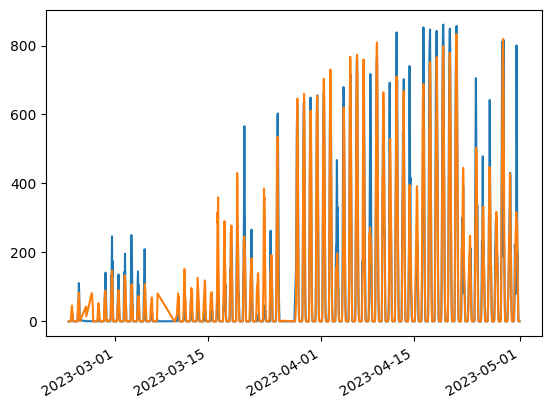

In [ ]:
df = test_b.copy()
b_pred = predictor_b.predict(test_b)
b_pred = np.where(b_pred < 0.05, 0, b_pred)
df["prediction"] = b_pred

# df = pd.merge(df, targets_a, left_index=True, right_index=True)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

print(f"Mean Absolute Error: {mae}")

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot() 

### How it does on validation set

2023-02-09 12:00:00    77.949921
2023-02-16 10:00:00    70.393536
2023-02-14 09:00:00    68.963972
2023-02-20 10:00:00    67.863229
2022-11-03 10:00:00    65.720449
Name: error, dtype: float64

Mean Absolute Error: 4.924165245782289
MAE for the last 1000 values: 5.315848935355781


<AxesSubplot: >

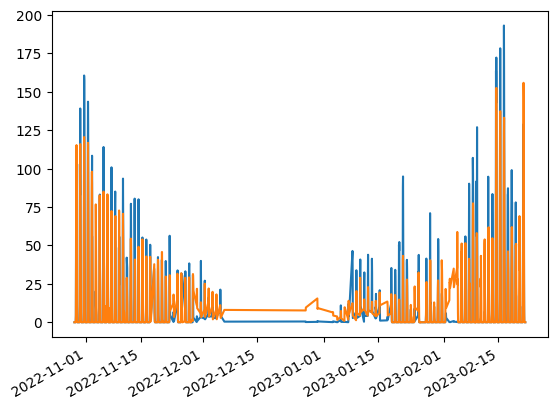

In [ ]:
df = val_b.copy()
b_pred = predictor_b.predict(val_b)
b_pred = np.where(b_pred < 0.05, 0, b_pred)
df["prediction"] = b_pred

# df = pd.merge(df, targets_a, left_index=True, right_index=True)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

print(f"Mean Absolute Error: {mae}")

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot() 

### Predicting on the actual test set

In [ ]:
### Location B
B_pred = predictor_b.predict(X_test_estimated_b)
B_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(B_pred), 4):
    B_pred_hourly.append(B_pred[i])

### Visualizing how the model predicts on the actual test set

In [ ]:
# df = X_test_estimated_b.copy()
# df["prediction"] = predictor_b.predict(X_test_estimated_b)

# start = "05-2023"
# end = "08-2023"
# feature = "direct_rad:W"

# utils4.plot_ts1([df["prediction"]], [df], start, end, feature, shareX=False)



### Storing the predictions

In [ ]:
predictions = np.array(B_pred_hourly)
# remove negative and small positive predictions
predictions = np.where(predictions < 0.05, 0, predictions)
ids = range(720, 720 + len(predictions))
df = pd.DataFrame({"id": ids, "prediction": predictions})

import os

directory = "saves/B/"
base_filename = "autogluon_B.csv"

# Find the next available number to append to the filename
i = 1
while True:
    filename = os.path.join(directory, f"{base_filename[:-4]}_{i}.csv")
    if not os.path.isfile(filename):
        break
    i += 1

# Save the DataFrame to the new filename
df.to_csv(filename, index=False)

## Example code for Location C

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
import numpy as np
import utils4
from sklearn.metrics import mean_absolute_error

### Reading in files and indexing them on time

In [ ]:

targets_c = TabularDataset('../data/C/train_targets.parquet')
targets_c = targets_c.set_index("time")

In [ ]:
X_train_observed_c = TabularDataset('../data/C/X_train_observed.parquet')
X_train_observed_c = X_train_observed_c.set_index("date_forecast")

In [ ]:
X_train_estimated_c = TabularDataset('../data/C/X_train_estimated.parquet')
X_train_estimated_c = X_train_estimated_c.set_index("date_forecast")

In [ ]:
X_test_estimated_c = TabularDataset('../data/C/X_test_estimated.parquet')
X_test_estimated_c = X_test_estimated_c.set_index("date_forecast")

### Data Preprocessing

In [ ]:
# removing rows where pv_measurment remains the same for more than 18 hours.
targets_c = utils4.remove_constant_values(targets_c, "pv_measurement", 18).dropna()

In [ ]:
def create_features(df):
    new_df = df.copy()
    # new_df['hour'] = new_df.index.hour
    # new_df['dayofweek'] = new_df.index.dayofweek
    # new_df['quarter'] = new_df.index.quarter
    # new_df['month'] = new_df.index.month
    # new_df['year'] = new_df.index.year
    new_df['dayofyear'] = new_df.index.dayofyear
    # new_df['dayofmonth'] = new_df.index.day
    new_df['weekofyear'] = new_df.index.isocalendar().week.astype(int)
    return new_df

In [ ]:
### Adding more time based features to the datasets
X_train_observed_c = create_features(X_train_observed_c)

X_train_estimated_c = create_features(X_train_estimated_c)

X_test_estimated_c = create_features(X_test_estimated_c)

In [ ]:
X_train_estimated_c.columns

Index(['date_calc', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wi

In [ ]:
def mark_correct_type(df):
    df['snow_drift:idx'] = df['snow_drift:idx'].astype("category")
    df['snow_density:kgm3'] = df['snow_density:kgm3'].astype("float")
    df['precip_type_5min:idx'] = df['precip_type_5min:idx'].astype("category")
    df['dew_or_rime:idx'] = df['dew_or_rime:idx'].astype("category")
    return df


In [ ]:
# X_train_observed_c= mark_correct_type(X_train_observed_c)

# X_train_estimated_c = mark_correct_type(X_train_estimated_c)

# X_test_estimated_c = mark_correct_type(X_test_estimated_c)

In [ ]:
def add_15min_fts(df, columns):
    for column in columns:
        df[column+'15'] = df[column].shift(-1)
        df[column+'30'] = df[column].shift(-2)
        df[column+'45'] = df[column].shift(-3)
    return df

In [ ]:
columns = []

X_train_observed_c = add_15min_fts(X_train_observed_c, columns=columns)

X_train_estimated_c = add_15min_fts(X_train_estimated_c, columns=columns)

X_test_estimated_c = add_15min_fts(X_test_estimated_c, columns=columns)


In [ ]:
### Using only observed weather for training
# Join the y values into x-dataframes for training
train_c = pd.merge(X_train_observed_c, targets_c, left_index=True, right_index=True)

In [ ]:
### Using only observed weather for training
# Join the y values into x-dataframes for training
test_c = pd.merge(X_train_estimated_c, targets_c, left_index=True, right_index=True)

# Remove 'date_calc' from test set and kaggle set
test_c.drop(columns=['date_calc'], inplace=True)
X_test_estimated_c.drop(columns=['date_calc'], inplace=True)

In [ ]:
# List of column names to drop
columns_to_drop = [

 'air_density_2m:kgm3', 
 'ceiling_height_agl:m', 
 'cloud_base_agl:m', 
 'dew_or_rime:idx',
 'effective_cloud_cover:p',
 'elevation:m',
 'fresh_snow_1h:cm', 
 'fresh_snow_24h:cm', 
 'is_day:idx',
 'is_in_shadow:idx',
 'msl_pressure:hPa',
 'precip_5min:mm', 
 'precip_type_5min:idx',
 'pressure_100m:hPa',
 'pressure_50m:hPa', 
 'prob_rime:p', 
 'rain_water:kgm2', 
 'relative_humidity_1000hPa:p', 
 'sfc_pressure:hPa',
 'snow_density:kgm3',
 'snow_drift:idx', 
 'snow_water:kgm2',
 'sun_azimuth:d',
 'super_cooled_liquid_water:kgm2',
 't_1000hPa:K', 
 'total_cloud_cover:p',
 'visibility:m', 
 'wind_speed_10m:ms',
 'wind_speed_u_10m:ms',
 'wind_speed_v_10m:ms'


]

# Drop the specified columns from the DataFrames
train_c = train_c.drop(columns=columns_to_drop)

test_c = test_c.drop(columns=columns_to_drop)

X_test_estimated_c = X_test_estimated_c.drop(columns=columns_to_drop)

In [ ]:
def split(df):
    midpoint = len(df)//2
    front = df.iloc[:midpoint]
    end = df.iloc[midpoint:]
    return front, end

def split1000(df):
    midpoint = len(df)//2
    front = df.iloc[:-1000]
    end = df.iloc[-1000:]
    return front, end

def sample_days(df, testfrac=0.55):
    # Extract unique dates from the datetime index as a list of date objects
    unique_dates = np.unique(df.index.date)
    
    combined_dates = []
    
    # Iterate through the unique dates and add all hours for each date
    for date in unique_dates:
        hours_for_date = df[df.index.date == date].index.time
        
        ### If you want all datapoints:
        # combined_dates.extend([pd.Timestamp(date) + pd.DateOffset(hours=hour.hour) for hour in hours_for_date])
        
        ### Only where all 24 hours are present for a date:
        if len(hours_for_date) == 24:
            combined_dates.extend([pd.Timestamp(date) + pd.DateOffset(hours=hour.hour) for hour in hours_for_date])
    
    one = pd.Series(combined_dates).sample(frac=testfrac, random_state=35)
    two = pd.Series(combined_dates)[~pd.Series(combined_dates).isin(one)]
    
    test = df[df.index.isin(one)]
    val = df[df.index.isin(two)]
    
    return val, test

In [ ]:
# Throw in some estimated weather to training as validation set, and the rest for testing
val_c, test_c = split(test_c)

### Create our model

### Location C

In [ ]:
predictor_c = TabularPredictor(label='pv_measurement', eval_metric='mean_absolute_error').fit(train_c,
                                                                                            tuning_data=val_c, 
                                                                                            # presets='best_quality',
                                                                                            # use_bag_holdout=True,
                                                                                            # # num_bag_folds=5, 
                                                                                            # # num_bag_sets=1, 
                                                                                            # # num_stack_levels=3,
                                                                                            # excluded_model_types=excluded_model_types
                                                                                            )

No path specified. Models will be saved in: "AutogluonModels\ag-20231108_112637\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20231108_112637\"
AutoGluon Version:  0.8.2
Python Version:     3.10.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   313.21 GB / 510.77 GB (61.3%)
Train Data Rows:    16041
Train Data Columns: 17
Tuning Data Rows:    1166
Tuning Data Columns: 17
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (999.6, 0.0, 118.71007, 195.02142)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fittin

In [ ]:
# predictor_c = TabularPredictor.load('AutogluonModels/best_c')

In [ ]:
predictor_c.leaderboard(test_c, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetTorch,-34.858738,-6.171607,0.037513,0.008302,9.192273,0.037513,0.008302,9.192273,1,True,10
1,WeightedEnsemble_L2,-35.244255,-5.753446,0.117194,0.144011,14.638217,0.015307,0.000000,0.228145,2,True,12
2,CatBoost,-38.794289,-7.737143,0.032426,0.000000,2.679584,0.032426,0.000000,2.679584,1,True,6
3,LightGBMXT,-39.838709,-7.308401,0.015997,0.005850,1.859173,0.015997,0.005850,1.859173,1,True,3
4,XGBoost,-44.189343,-7.703783,0.028370,0.000000,0.493867,0.028370,0.000000,0.493867,1,True,9
5,LightGBM,-45.021563,-8.165778,0.010096,0.005964,0.590123,0.010096,0.005964,0.590123,1,True,4
6,KNeighborsUnif,-48.545300,-9.086432,0.048378,0.129859,3.358626,0.048378,0.129859,3.358626,1,True,1
7,NeuralNetFastAI,-49.022423,-8.918217,0.059747,0.023631,14.190750,0.059747,0.023631,14.190750,1,True,8
8,KNeighborsDist,-49.217221,-9.262500,0.032358,0.013541,0.015934,0.032358,0.013541,0.015934,1,True,2
9,RandomForestMSE,-49.604333,-8.549842,0.448391,0.063615,7.806580,0.448391,0.063615,7.806580,1,True,5


In [ ]:
predictor_c.feature_importance(test_c, )

Computing feature importance via permutation shuffling for 17 features using 1166 rows with 5 shuffle sets...
	7.82s	= Expected runtime (1.56s per shuffle set)
	3.05s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
direct_rad:W,20.258052,1.404430,0.000003,5,23.149793,17.366310
direct_rad_1h:J,19.485752,1.421385,0.000003,5,22.412403,16.559101
clear_sky_energy_1h:J,19.075803,1.188612,0.000002,5,21.523171,16.628435
clear_sky_rad:W,14.722840,1.298318,0.000007,5,17.396093,12.049586
diffuse_rad:W,10.981188,1.105888,0.000012,5,13.258225,8.704150
diffuse_rad_1h:J,10.812217,0.606425,0.000001,5,12.060854,9.563580
fresh_snow_12h:cm,5.025489,1.167968,0.000326,5,7.430353,2.620626
sun_elevation:d,4.763054,0.653133,0.000041,5,6.107863,3.418244
fresh_snow_3h:cm,3.110865,0.843306,0.000589,5,4.847245,1.374486
dew_point_2m:K,2.749957,0.353137,0.000032,5,3.477072,2.022842


#### Using the weather forecast part of the training data as a dummy unseen test set

2023-04-14 11:00:00    404.959079
2023-04-28 09:00:00    392.132656
2023-03-27 12:00:00    346.471726
2023-03-27 11:00:00    317.606681
2023-03-27 10:00:00    308.530646
Name: error, dtype: float64

Mean Absolute Error: 35.24333624299315
MAE for the last 1000 values: 38.38122172056154


<AxesSubplot: >

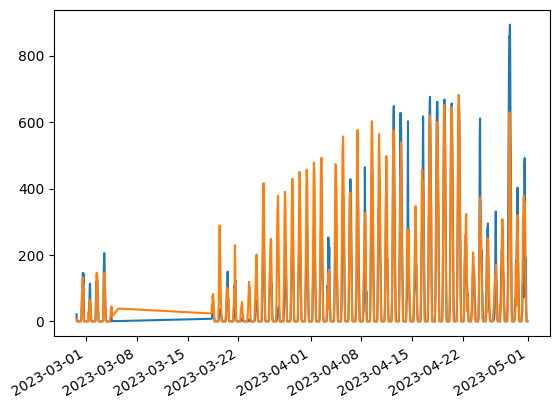

In [ ]:
df = test_c.copy()
c_pred = predictor_c.predict(test_c)
c_pred = np.where(c_pred < 0.05, 0, c_pred)
df["prediction"] = c_pred

# df = pd.merge(df, targets_a, left_index=True, right_index=True)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

print(f"Mean Absolute Error: {mae}")

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot() 

### Predicting on the actual test set

In [ ]:
### Location C
C_pred = predictor_c.predict(X_test_estimated_c)
C_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(C_pred), 4):
    C_pred_hourly.append(C_pred[i])  

### Visualizing how the model predicts on the actual test set

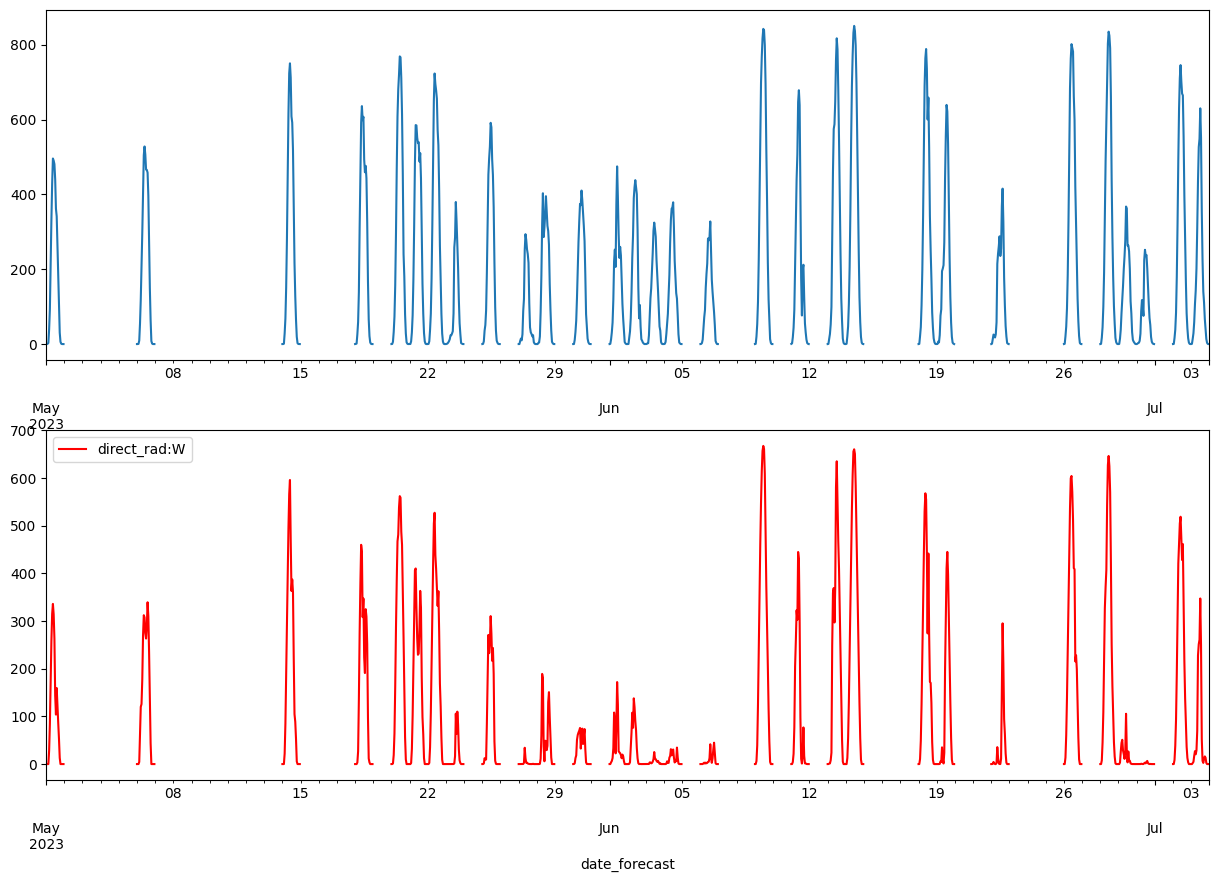

In [ ]:
df = X_test_estimated_c.copy()
df["prediction"] = predictor_c.predict(X_test_estimated_c)

start = "05-2023"
end = "08-2023"
feature = "direct_rad:W"

utils4.plot_ts1([df["prediction"]], [df], start, end, feature, shareX=False)

### Storing the predictions

In [ ]:
predictions = np.array(C_pred_hourly)
# remove negative and small positive predictions
predictions = np.where(predictions < 0.05, 0, predictions)
ids = range(1440, 1440 + len(predictions))
df = pd.DataFrame({"id": ids, "prediction": predictions})

import os

directory = "saves/C/"
base_filename = "autogluon_C.csv"

# Find the next available number to append to the filename
i = 1
while True:
    filename = os.path.join(directory, f"{base_filename[:-4]}_{i}.csv")
    if not os.path.isfile(filename):
        break
    i += 1

# Save the DataFrame to the new filename
df.to_csv(filename, index=False)